### Table of Contents

1. [Logistic Regression](#chapter1)
    1. [Loading dataset](#section_1_1)
    2. [Data Cleaning](#section_1_2)
    3. [Features](#section_1_2_1)
    4. [Preprocessing](#section_1_2_2)
    5. [Statsmodel Logistic Regresion](#section_1_2_3)
    6. [Scikit Learn Logistic Regresion](#section_1_2_4)
        1. [Manual Calculation of P-value](#section_1_2_5)
2. [Glmnet, Ridge, and Lasso Regression](#2)
    1. [Ridge Regression](#21)
    2. [Glmnet ElasticNet Regression](#21)
    3. [Lasso Regression](#23)

# Logistic Regression and Feature Selection of Home Credit Default Risk  <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.model_selection import train_test_split

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

### Loading dataset from LightGBM aggregations + feature engineering  <a class="anchor" id="section_1_1"></a>
Shape: {356251, 828}
Training data: {307507, 828}
Testing data: {48744, 828}

In [2]:
tt=pd.read_csv('o_full_train')

### Data Cleaning <a class="anchor" id="section_1_2"></a>
Removing columns with large number of missing values, imputing NA's with median

In [3]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [4]:
# splitting training and test data
train= tt[tt['TARGET'].notnull()]
test = tt[tt['TARGET'].isnull()]
ttarget=test['TARGET']
target = train['TARGET']

In [5]:
train, test = remove_missing_columns(train,test)
train['TARGET']=target

There are 27 columns with greater than 90% missing values.


In [6]:
# getting rid of infinity values
train=train.replace([np.inf, -np.inf], np.nan)
test=test.replace([np.inf, -np.inf], np.nan)

In [7]:
# imputing median
train.fillna(train.median(),inplace=True)
test.fillna(test.median(),inplace=True)
test['TARGET']=ttarget

### Features <a class="anchor" id="section_1_2_1"></a>
- Features taken from Top 100 in gain feature importance from LightGBM model (ROC AUC Local CV: 0.8005): *insert link here*
- Commented out features with large p-values after statsmodels logistic regression analysis (p>0.005) but with interesting interaction with other more important features (different from deleted list below)

In [8]:
feature_cols=['NEW_EXT_SOURCES_MEAN', 'prev_score_mean', 'buro_score_sum',
       'buro_score_mean', 'INTEREST', 'prev_score_max',
       'app EXT_SOURCE_1 / DAYS_BIRTH', 'AMT_ANNUITY',
       'app EXT_SOURCE_2 * DAYS_EMPLOYED', 
    'CNT_PAYMENT', 
              'DAYS_BIRTH',
       'app EXT_SOURCE_2 * EXT_SOURCE_3', 'NEW_CREDIT_TO_GOODS_RATIO',
       'buro_score_recent2y_sum', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'CODE_GENDER',
       'LATE_PAYMENT', 'EXT_SOURCE_2', 'prev_score_last',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX', 
              'CRED_UTIL_2', 'AMT_CREDIT',
       'DAYS_ID_PUBLISH', 'buro_score_max', 
              'app EXT_SOURCE_3 / DAYS_BIRTH',
       'ACTIVE_AMT_CREDIT_SUM_SUM', 'app EXT_SOURCE_3 * DAYS_EMPLOYED',
       'NAME_EDUCATION_TYPE_Higher education', 
              'app EXT_SOURCE_2 / DAYS_BIRTH',
       'NEW_ANNUITY_TO_INCOME_RATIO', 
              'REGION_POPULATION_RELATIVE',
       'PREV_days_late_due_MIN', 'DAYS_EMPLOYED',
       'BURO_AMT_CREDIT_DEBT_RATE_VAR', 'INSTAL_AMT_PAYMENT_SUM',
       'buro_score_var', 'POS_MONTHS_BALANCE_MAX', 'CLOSED_DAYS_CREDIT_MAX',
       'DAYS_REGISTRATION', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 
              'OWN_CAR_AGE',
       'NEW_EMPLOY_TO_BIRTH_RATIO', 'prev_score_var', 'INSTAL_DPD_MEAN',
       'POS_MONTHS_BALANCE_MEAN', 'APPROVED_DAYS_DECISION_MAX', 'EXT_SOURCE_3',
       'INTEREST_SHARE', 
              'NEW_CREDIT_TO_ANNUITY_RATIO/3',
       'INSTAL_AMT_PAYMENT_MIN', 
              'app EXT_SOURCE_1 * EXT_SOURCE_2',
       'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 
              'NAME_FAMILY_STATUS_Married',
       '60_DAYSAMT_PAYMENT_MIN', 
              'NEW_CAR_TO_BIRTH_RATIO',
       'ACTIVE_DAYS_CREDIT_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MAX',
       'buro_score_last', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
       'prev_score_recent2y_sum', 'INSTAL_AMT_PAYMENT_MEAN',
       'NEW_PHONE_TO_EMPLOY_RATIO', 
              'REGION_RATING_CLIENT_W_CITY',
       'POS_MONTHS_BALANCE_SIZE', 
              'INSTAL_DBD_MEAN',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'PREV_days_late_due_MEAN', 
              'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
       'AMT_GOODS_PRICE', 
              'CLOSED_AMT_CREDIT_SUM_MEAN',
       'DEF_30_CNT_SOCIAL_CIRCLE',
             'NEW_SCORES_STD', 'NEW_CREDIT_TO_INCOME_RATIO', 'BURO_AMT_CREDIT_DEBT_RATE_MAX', 'NEW_RATIO_BURO_AMT_CREDIT_SUM_MEAN', 'BURO_AMT_CREDIT_SUM_SUM', 'INSTAL_PAYMENT_DIFF_MEAN', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'NEW_RATIO_BURO_DAYS_CREDIT_MAX', 'POS_NAME_CONTRACT_STATUS_Active_MEAN', 'INSTAL_DBD_SUM', 'PREV_APP_CREDIT_PERC_VAR', 'NEW_CAR_TO_EMPLOY_RATIO', 'BURO_DAYS_CREDIT_MAX', 'INSTAL_PAYMENT_PERC_SUM', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR', 'APPROVED_INTEREST_SHARE_MEAN', 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX', 'NEW_PHONE_TO_BIRTH_RATIO', 'INSTAL_AMT_INSTALMENT_SUM', 'NEW_DOC_IND_KURT', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'PREV_DAYS_DECISION_MEAN', 'PREV_DAYS_DECISION_MAX', 'APPROVED_AMT_DOWN_PAYMENT_MAX', 'NEW_SOURCES_PROD', 'APPROVED_DAYS_DECISION_MEAN', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN']

In [9]:
feature_cols=['NEW_EXT_SOURCES_MEAN',
 'prev_score_mean',
 'buro_score_sum',
 'buro_score_mean',
 'INTEREST',
 'prev_score_max',
 'app EXT_SOURCE_1 / DAYS_BIRTH',
 'app EXT_SOURCE_2 * DAYS_EMPLOYED',
 'CNT_PAYMENT',
 'DAYS_BIRTH',
 'app EXT_SOURCE_2 * EXT_SOURCE_3',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'buro_score_recent2y_sum',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'CODE_GENDER',
 'LATE_PAYMENT',
 'EXT_SOURCE_2',
 'prev_score_last',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX',
 'CRED_UTIL_2',
 'AMT_CREDIT',
 'DAYS_ID_PUBLISH',
 'buro_score_max',
 'app EXT_SOURCE_3 / DAYS_BIRTH',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'app EXT_SOURCE_3 * DAYS_EMPLOYED',
 'NAME_EDUCATION_TYPE_Higher education',
 'app EXT_SOURCE_2 / DAYS_BIRTH',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'REGION_POPULATION_RELATIVE',
 'PREV_days_late_due_MIN',
 'DAYS_EMPLOYED',
 'INSTAL_AMT_PAYMENT_SUM',
 'buro_score_var',
 'POS_MONTHS_BALANCE_MAX',
 'CLOSED_DAYS_CREDIT_MAX',
 'DAYS_REGISTRATION',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'OWN_CAR_AGE',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'prev_score_var',
 'APPROVED_DAYS_DECISION_MAX',
 'EXT_SOURCE_3',
 'INTEREST_SHARE',
 'NEW_CREDIT_TO_ANNUITY_RATIO/3',
 'app EXT_SOURCE_1 * EXT_SOURCE_2',
 'NAME_FAMILY_STATUS_Married',
 '60_DAYSAMT_PAYMENT_MIN',
 'NEW_CAR_TO_BIRTH_RATIO',
 'ACTIVE_DAYS_CREDIT_MAX',
 'buro_score_last',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'prev_score_recent2y_sum',
 'INSTAL_AMT_PAYMENT_MEAN',
 'REGION_RATING_CLIENT_W_CITY',
 'POS_MONTHS_BALANCE_SIZE',
 'INSTAL_DBD_MEAN',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'PREV_days_late_due_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'AMT_GOODS_PRICE',
 'CLOSED_AMT_CREDIT_SUM_MEAN',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'NEW_SCORES_STD',
 'NEW_CREDIT_TO_INCOME_RATIO',
 'BURO_AMT_CREDIT_DEBT_RATE_MAX',
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
 'INSTAL_DBD_SUM',
 'NEW_CAR_TO_EMPLOY_RATIO',
 'BURO_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR',
 'APPROVED_INTEREST_SHARE_MEAN',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
 'NEW_PHONE_TO_BIRTH_RATIO',
 'INSTAL_AMT_INSTALMENT_SUM',
 'NEW_DOC_IND_KURT',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'PREV_DAYS_DECISION_MEAN',
 'PREV_DAYS_DECISION_MAX',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'NEW_SOURCES_PROD',
 'APPROVED_DAYS_DECISION_MEAN',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN']

In [10]:
feature_cols=['NEW_EXT_SOURCES_MEAN', 'prev_score_mean', 'buro_score_sum',
       'buro_score_mean', 'INTEREST', 'prev_score_max',
       'app EXT_SOURCE_1 / DAYS_BIRTH', 'AMT_ANNUITY',
       #’app EXT_SOURCE_2 * DAYS_EMPLOYED', 
    'CNT_PAYMENT', 
              'DAYS_BIRTH',
       'app EXT_SOURCE_2 * EXT_SOURCE_3', 'NEW_CREDIT_TO_GOODS_RATIO',
       'buro_score_recent2y_sum', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'CODE_GENDER',
       'LATE_PAYMENT', 'EXT_SOURCE_2', 'prev_score_last',
    'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX', 
              'CRED_UTIL_2', 'AMT_CREDIT',
       'DAYS_ID_PUBLISH', 'buro_score_max', 
              'app EXT_SOURCE_3 / DAYS_BIRTH',
      # 'ACTIVE_AMT_CREDIT_SUM_SUM', 'app EXT_SOURCE_3 * DAYS_EMPLOYED',
       'NAME_EDUCATION_TYPE_Higher education', 
              'app EXT_SOURCE_2 / DAYS_BIRTH',
       'NEW_ANNUITY_TO_INCOME_RATIO', 
              #’REGION_POPULATION_RELATIVE',
       'PREV_days_late_due_MIN', 'DAYS_EMPLOYED',
       'BURO_AMT_CREDIT_DEBT_RATE_VAR', #’INSTAL_AMT_PAYMENT_SUM',
       #’buro_score_var', 
'POS_MONTHS_BALANCE_MAX', 'CLOSED_DAYS_CREDIT_MAX',
       'DAYS_REGISTRATION', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 
              'OWN_CAR_AGE',
       'NEW_EMPLOY_TO_BIRTH_RATIO', 
#’prev_score_var', 'INSTAL_DPD_MEAN',
       #’POS_MONTHS_BALANCE_MEAN', #’APPROVED_DAYS_DECISION_MAX', 'EXT_SOURCE_3',
      # 'INTEREST_SHARE', 
              'NEW_CREDIT_TO_ANNUITY_RATIO/3',
       'INSTAL_AMT_PAYMENT_MIN', 
              'app EXT_SOURCE_1 * EXT_SOURCE_2',
       'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 
              'NAME_FAMILY_STATUS_Married',
       #’60_DAYSAMT_PAYMENT_MIN', 
              'NEW_CAR_TO_BIRTH_RATIO',
       #‘ACTIVE_DAYS_CREDIT_MAX', #’BURO_DAYS_CREDIT_ENDDATE_MAX',
      # 'buro_score_last', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
       'prev_score_recent2y_sum', 'INSTAL_AMT_PAYMENT_MEAN',
       'NEW_PHONE_TO_EMPLOY_RATIO', 
              'REGION_RATING_CLIENT_W_CITY',
       'POS_MONTHS_BALANCE_SIZE', 
             # 'INSTAL_DBD_MEAN',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
      # 'PREV_days_late_due_MEAN', 
             # 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
       #’AMT_GOODS_PRICE', 
              #’CLOSED_AMT_CREDIT_SUM_MEAN'
       'DEF_30_CNT_SOCIAL_CIRCLE']

#### Deleted Features (large p-value after statsmodels logistic regression analysis)
['NEW_SCORES_STD',
       'NEW_CREDIT_TO_INCOME_RATIO', 'BURO_AMT_CREDIT_DEBT_RATE_MAX',
       'NEW_RATIO_BURO_AMT_CREDIT_SUM_MEAN', 'BURO_AMT_CREDIT_SUM_SUM',
       'INSTAL_PAYMENT_DIFF_MEAN', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
       'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
       'POS_NAME_CONTRACT_STATUS_Active_MEAN', 'INSTAL_DBD_SUM',
       'PREV_APP_CREDIT_PERC_VAR', 'NEW_CAR_TO_EMPLOY_RATIO',
       'BURO_DAYS_CREDIT_MAX', 'INSTAL_PAYMENT_PERC_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR', 'APPROVED_INTEREST_SHARE_MEAN',
       'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX', 'NEW_PHONE_TO_BIRTH_RATIO', 'INSTAL_AMT_INSTALMENT_SUM',
       'NEW_DOC_IND_KURT', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
       'PREV_DAYS_DECISION_MEAN', 'PREV_DAYS_DECISION_MAX',
       'APPROVED_AMT_DOWN_PAYMENT_MAX', 'NEW_SOURCES_PROD',
       'APPROVED_DAYS_DECISION_MEAN', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',]

### Preprocessing <a class="anchor" id="section_1_2_2"></a>
- Separated training and test data
- Scaled training data (BIG improvement in ROC AUC - from 0.51 to 0.78)

In [11]:
#feature_cols = [f for f in train.columns if f not in
#['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index','Unnamed: 0']]

#main training set
y = train.TARGET
X = train[feature_cols]

#for use in later regressions
y1=train.TARGET 
X1=train[feature_cols]

#test set
X_test=test[feature_cols]
y_test=test.TARGET

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X)
scaled_train = scaler.transform(X)
scaler.fit(X1)
scaled_train1 = scaler.transform(X1)
X = pd.DataFrame(scaled_train, index=X.index, columns=X.columns)
X1 = pd.DataFrame(scaled_train1, index=X1.index, columns=X1.columns)

### Statsmodel Logistic Regression <a class="anchor" id="section_1_2_3"></a>
Determining p-values for coefficients to help with feature selection as well as provide another dimension of feature importance

In [12]:
X_train = sm.add_constant(X1)
est1 = sm.Logit(y, X_train).fit()
stats=pd.DataFrame()
stats=est1.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.239726
         Iterations 17


In [13]:
stats_html = stats.as_html()
stats=pd.read_html(stats_html, header=0, index_col=0)[0]

In [14]:
stats=stats.rename(columns={'P>|z|': 'pval'})
stats.head(50) #first 50

,coef,std err,z,pval,[0.025,0.975]
const,-5.9052,0.631,-9.355,0.000,-7.142,-4.668
NEW_EXT_SOURCES_MEAN,-1.7327,0.111,-15.636,0.000,-1.950,-1.516
prev_score_mean,3.0259,0.184,16.410,0.000,2.664,3.387
buro_score_sum,9.5643,1.069,8.948,0.000,7.469,11.659
buro_score_mean,1.4844,0.208,7.120,0.000,1.076,1.893
INTEREST,-0.7917,0.057,-13.846,0.000,-0.904,-0.680
prev_score_max,1.2627,0.141,8.934,0.000,0.986,1.540
app EXT_SOURCE_1 / DAYS_BIRTH,1.6279,0.133,12.246,0.000,1.367,1.888
AMT_ANNUITY,2.2588,0.369,6.119,0.000,1.535,2.982
CNT_PAYMENT,1.2495,0.062,20.019,0.000,1.127,1.372


In [15]:
stats.tail(51) #last 51

,coef,std err,z,pval,[0.025,0.975]
const,-5.9052,0.631,-9.355,0.000,-7.142,-4.668
NEW_EXT_SOURCES_MEAN,-1.7327,0.111,-15.636,0.000,-1.950,-1.516
prev_score_mean,3.0259,0.184,16.410,0.000,2.664,3.387
buro_score_sum,9.5643,1.069,8.948,0.000,7.469,11.659
buro_score_mean,1.4844,0.208,7.120,0.000,1.076,1.893
INTEREST,-0.7917,0.057,-13.846,0.000,-0.904,-0.680
prev_score_max,1.2627,0.141,8.934,0.000,0.986,1.540
app EXT_SOURCE_1 / DAYS_BIRTH,1.6279,0.133,12.246,0.000,1.367,1.888
AMT_ANNUITY,2.2588,0.369,6.119,0.000,1.535,2.982
CNT_PAYMENT,1.2495,0.062,20.019,0.000,1.127,1.372


In [16]:
updated_fc=stats[stats['pval']<=0.005]
updated_fc=list(updated_fc.index)
updated_fc

['const',
 'NEW_EXT_SOURCES_MEAN',
 'prev_score_mean',
 'buro_score_sum',
 'buro_score_mean',
 'INTEREST',
 'prev_score_max',
 'app EXT_SOURCE_1 / DAYS_BIRTH',
 'AMT_ANNUITY',
 'CNT_PAYMENT',
 'DAYS_BIRTH',
 'app EXT_SOURCE_2 * EXT_SOURCE_3',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'buro_score_recent2y_sum',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'CODE_GENDER',
 'LATE_PAYMENT',
 'CRED_UTIL_2',
 'DAYS_ID_PUBLISH',
 'buro_score_max',
 'app EXT_SOURCE_3 / DAYS_BIRTH',
 'NAME_EDUCATION_TYPE_Higher education',
 'app EXT_SOURCE_2 / DAYS_BIRTH',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'PREV_days_late_due_MIN',
 'POS_MONTHS_BALANCE_MAX',
 'CLOSED_DAYS_CREDIT_MAX',
 'DAYS_REGISTRATION',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'OWN_CAR_AGE',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'NEW_CREDIT_TO_ANNUITY_RATIO/3',
 'app EXT_SOURCE_1 * EXT_SOURCE_2',
 'NAME_FAMILY_STATUS_Married',
 'NEW_CAR_TO_BIRTH_RATIO',
 'INSTAL_AMT_PAYMENT_MEAN',
 'REGION_RATING_CLIENT_W_CITY',
 'POS_MONTHS_BALANCE_SIZE',
 'NAME_EDUCATION_TYPE_Secondary / secon

### Scikit Learn Logistic Regression <a class="anchor" id="section_1_2_4"></a>
Used newton-cg solver for best results

In [17]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(
    C=1,
    max_iter=200,
    solver='newton-cg'
)

In [18]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [19]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LR Features (avg over folds)')
    plt.tight_layout
    plt.savefig('lr_importances01.png')

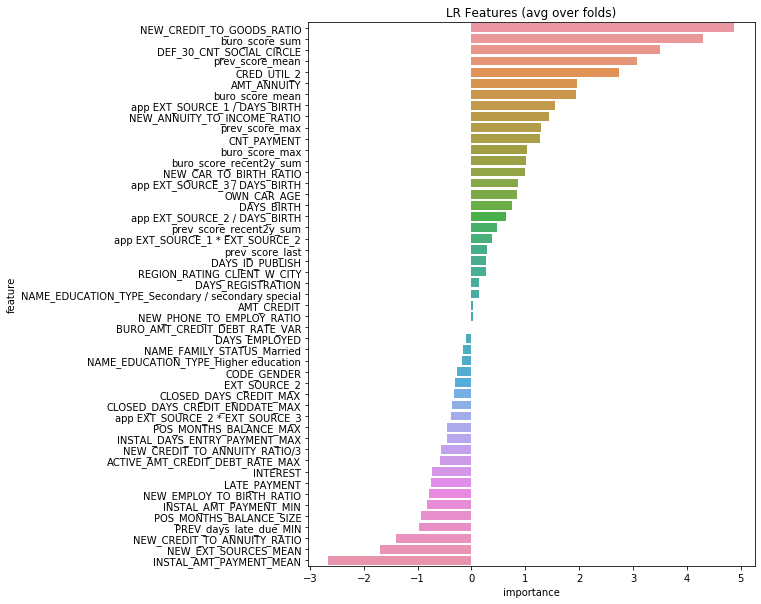

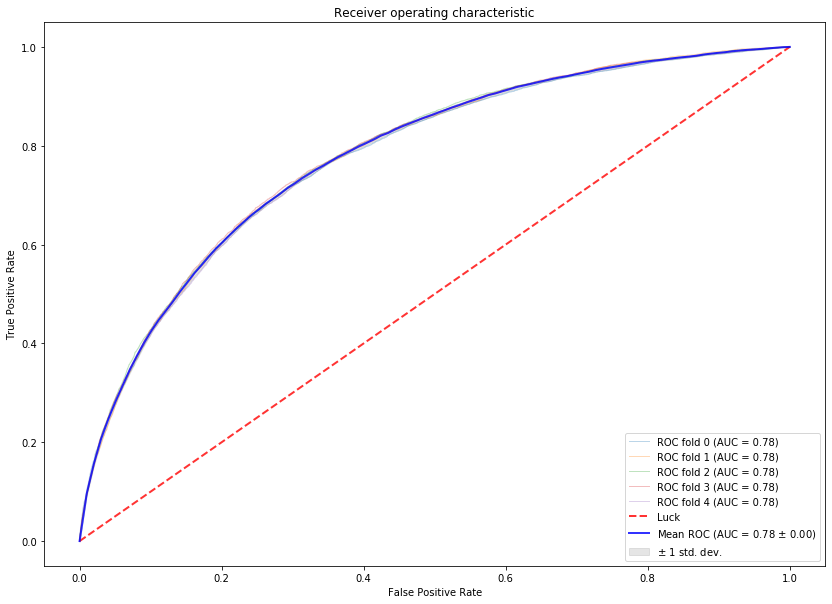

,AUC Train,AUC Test
0,0.781139,0.777159
1,0.780330,0.779519
2,0.779868,0.782070
3,0.779822,0.782491
4,0.780749,0.778738


In [20]:
cv = StratifiedKFold(n_splits=5, random_state=19, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train1, test1), i in zip(cv.split(X, y), range(5)):
    model=clf.fit(X.iloc[train1], y.iloc[train1])
    _, _, auc_score_train = compute_roc_auc(train1)
    fpr, tpr, auc_score = compute_roc_auc(test1)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    feature_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feature_cols
    fold_importance_df["importance"] = model.coef_[0]
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


display_importances(feature_importance_df)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

#### Manual Calculation of P-Value for Sklearn LR <a class="anchor" id="section_1_2_5"></a>

In [21]:
from scipy.stats import norm

In [22]:
l1=['const']
l2=X.columns.tolist()
cols=l1+l2

Forked from https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance

In [23]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

# test p-values
pvals=pd.DataFrame(logit_pvalue(clf, X),index=cols)

In [24]:
pvals.head(50)

,0
const,1.332268e-15
NEW_EXT_SOURCES_MEAN,0.000000e+00
prev_score_mean,0.000000e+00
buro_score_sum,2.711887e-05
buro_score_mean,0.000000e+00
INTEREST,0.000000e+00
prev_score_max,0.000000e+00
app EXT_SOURCE_1 / DAYS_BIRTH,0.000000e+00
AMT_ANNUITY,1.138715e-07
CNT_PAYMENT,0.000000e+00


## Glmnet, Ridge, and Lasso Regression <a class="anchor" id="2"></a>

In [25]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale 
from sklearn.metrics import mean_squared_error
import glmnet as glm
alphas = 10**np.linspace(10,-2,100)*0.5

### Experimenting with different alphas in Ridge Regression <a class="anchor" id="21"></a>
Comparing coefficients using varying penalties

In [26]:
X_train,X_test,y_train,y_test=train_test_split(X1,y1,test_size=0.2,random_state=19)

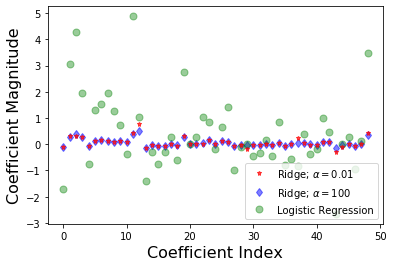

In [27]:
rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
rr.fit(X_train, y_train)
rr100 = Ridge(alpha=10) #  comparison with alpha value
rr100.fit(X_train, y_train)
train_score=clf.score(X_train, y_train)
test_score=clf.score(X_test, y_test)
Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)
Ridge_train_score100 = rr100.score(X_train,y_train)
Ridge_test_score100 = rr100.score(X_test, y_test)
plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') # alpha here is for transparency
plt.plot(clf.coef_[0],alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Logistic Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=10,loc=4)
plt.show()

### Glmnet Coefficients <a class="anchor" id="22"></a>

In [28]:
ridge1 = glm.ElasticNet(alpha=0, scoring='mean_squared_error')
ridge1.fit(X1, y1.to_numpy().ravel())
ridge1.lambda_max_

0.0060474654314884545

In [29]:
ridge1.lambda_best_

array([0.17223398])

In [30]:
pd.Series(ridge1.coef_path_[:,ridge1.lambda_max_inx_], index=X1.columns)

NEW_EXT_SOURCES_MEAN                                -0.108130
prev_score_mean                                      0.288879
buro_score_sum                                       0.411341
buro_score_mean                                      0.269152
INTEREST                                            -0.046568
prev_score_max                                       0.134891
app EXT_SOURCE_1 / DAYS_BIRTH                        0.143255
AMT_ANNUITY                                          0.146261
CNT_PAYMENT                                          0.072206
DAYS_BIRTH                                           0.097247
app EXT_SOURCE_2 * EXT_SOURCE_3                      0.058937
NEW_CREDIT_TO_GOODS_RATIO                            0.402954
buro_score_recent2y_sum                              0.664540
NEW_CREDIT_TO_ANNUITY_RATIO                         -0.089100
CODE_GENDER                                         -0.019924
LATE_PAYMENT                                        -0.076250
EXT_SOUR

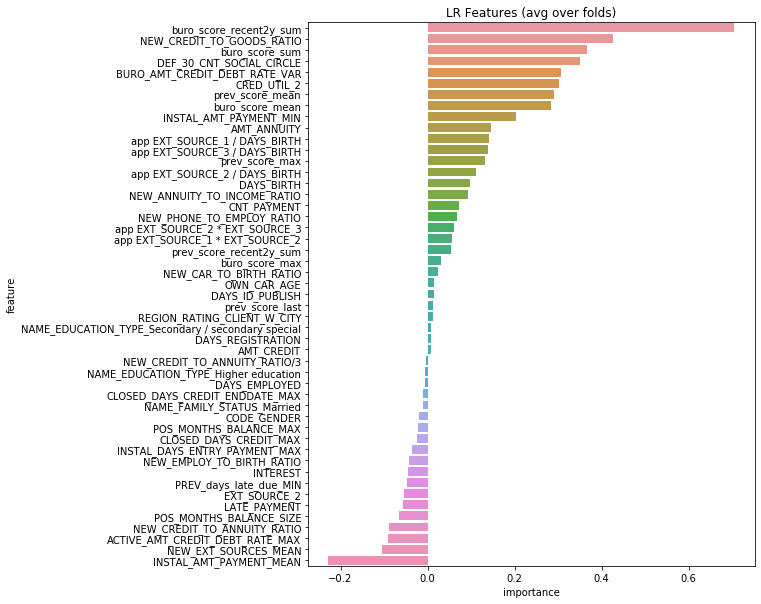

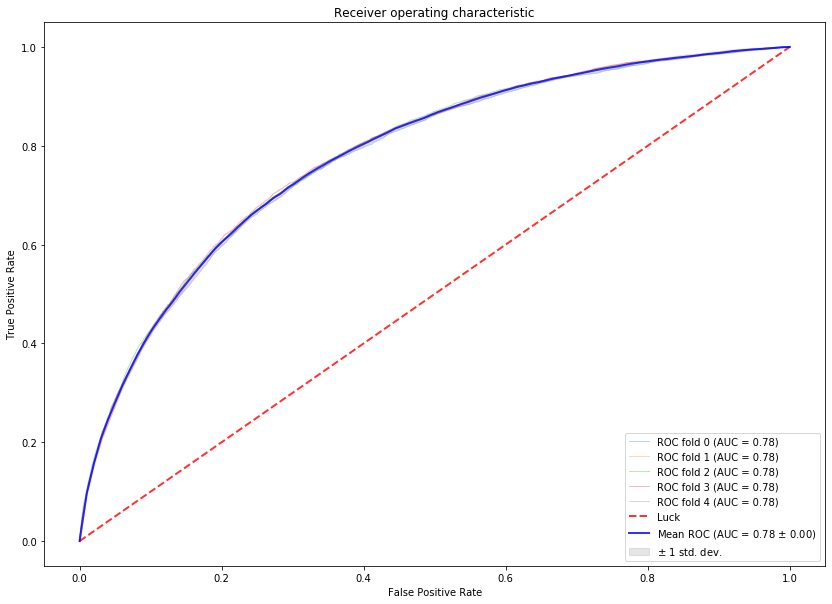

,AUC Train,AUC Test
0,0.781018,0.777626
1,0.780402,0.780089
2,0.779816,0.782427
3,0.779719,0.782845
4,0.780749,0.778738


In [31]:
cv = StratifiedKFold(n_splits=5, random_state=19, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train1, test1), i in zip(cv.split(X1, y1), range(5)):
    model=ridge1.fit(X.iloc[train1], y.iloc[train1])
    _, _, auc_score_train = compute_roc_auc(train1)
    fpr, tpr, auc_score = compute_roc_auc(test1)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    feature_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feature_cols
    fold_importance_df["importance"] = model.coef_path_[:,ridge1.lambda_max_inx_]
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


display_importances(feature_importance_df)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

### Lasso Coefficients and Feature Selection <a class="anchor" id="23"></a>

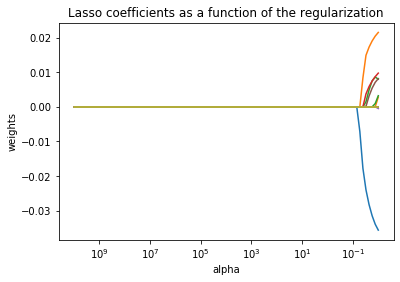

In [32]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X1), y1)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [33]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X1), y1.to_numpy().ravel())

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [34]:
lassocv.alpha_

6.04746543148847e-05

In [35]:
lasso.set_params(alpha=lassocv.alpha_)
lasso_model=lasso.fit(scale(X1), y1)

In [36]:
pd.Series(lasso.coef_, index=X.columns)

NEW_EXT_SOURCES_MEAN                                -0.018098
prev_score_mean                                      0.020640
buro_score_sum                                       0.005645
buro_score_mean                                      0.013184
INTEREST                                            -0.015316
prev_score_max                                       0.011616
app EXT_SOURCE_1 / DAYS_BIRTH                        0.012478
AMT_ANNUITY                                          0.007397
CNT_PAYMENT                                          0.028336
DAYS_BIRTH                                           0.028570
app EXT_SOURCE_2 * EXT_SOURCE_3                      0.013101
NEW_CREDIT_TO_GOODS_RATIO                            0.008558
buro_score_recent2y_sum                              0.009863
NEW_CREDIT_TO_ANNUITY_RATIO                         -0.025405
CODE_GENDER                                         -0.009441
LATE_PAYMENT                                        -0.001368
EXT_SOUR

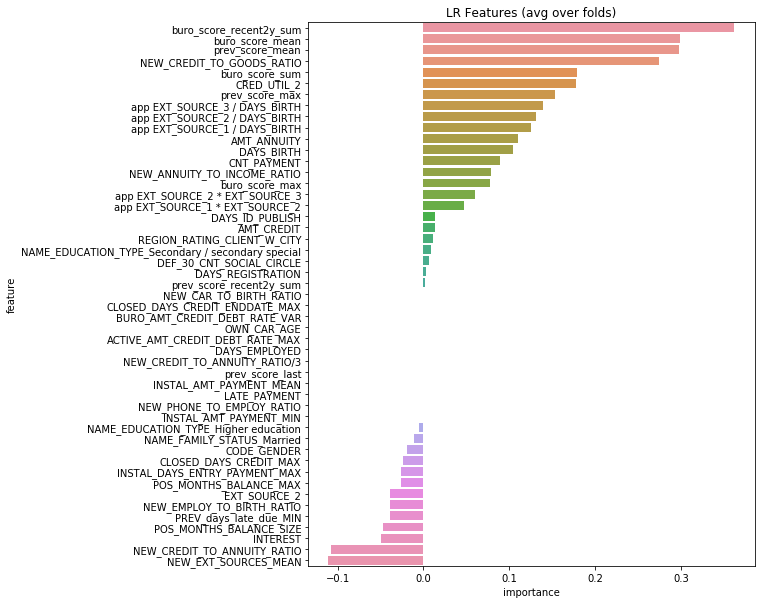

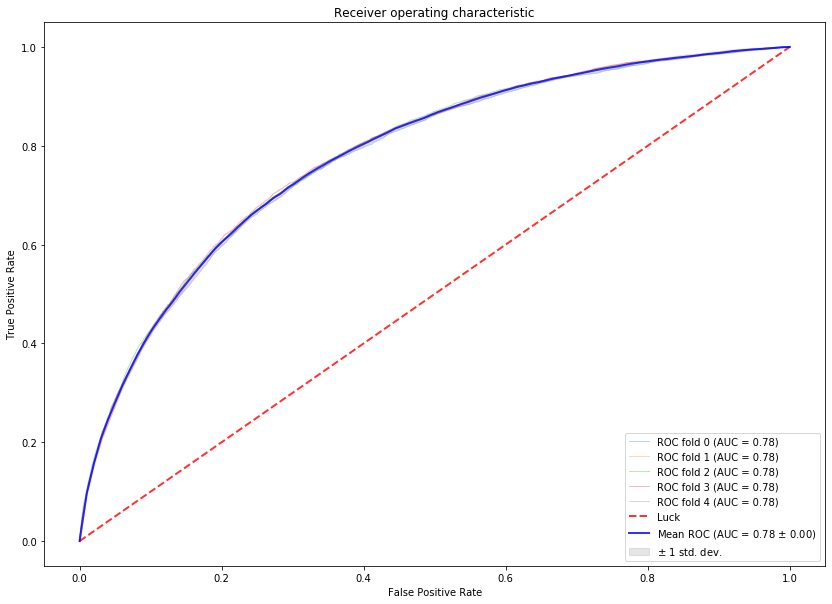

,AUC Train,AUC Test
0,0.781018,0.777626
1,0.780402,0.780089
2,0.779816,0.782427
3,0.779719,0.782845
4,0.780749,0.778738


In [37]:
cv = StratifiedKFold(n_splits=5, random_state=19, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train1, test1), i in zip(cv.split(X1, y1), range(5)):
    model=lasso_model.fit(X.iloc[train1], y.iloc[train1])
    _, _, auc_score_train = compute_roc_auc(train1)
    fpr, tpr, auc_score = compute_roc_auc(test1)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    feature_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feature_cols
    fold_importance_df["importance"] = model.coef_
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


display_importances(feature_importance_df)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])